# 4.4 - MAB Procedure

## Preparations

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import datetime
import random
import pickle
from sklearn.metrics import mean_squared_error
import openpyxl
from pathlib import Path
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import shap

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Loading and Preparing Taxi Data
path = ''
df_top20 = pd.read_csv(path+'Data/df_top20.csv')
df_complex_complete = pd.DataFrame()

for i in df_top20.groupby('PULocationID'):
    A = i[1]

    df_complex = pd.concat([A['datetime'], A['PULocationID'], 
                            A['PULocationID'].astype(str)+'-'+A['pickup_day_of_week'].astype(str), 
                            np.cos((A['pickup_hour']*2*np.pi)/24), np.sin((A['pickup_hour']*2*np.pi)/24), 
                            np.cos((A['pickup_hour']*2*np.pi)/12),  np.sin((A['pickup_hour']*2*np.pi)/12), A['count'], 
                            A['count'].shift(1), A['count'].shift(2),A['count'].shift(3), A['count'].shift(4),
                            A['count'].shift(5), A['count'].shift(6), A['count'].shift(7), A['count'].shift(8), 
                            A['count'].shift(9), A['count'].shift(10),A['count'].shift(11), A['count'].shift(12), 
                            A['count'].shift(13), A['count'].shift(14), A['count'].shift(15), A['count'].shift(16), 
                            A['count'].shift(17), A['count'].shift(18), A['count'].shift(19), A['count'].shift(20), 
                            A['count'].shift(21), A['count'].shift(22),   A['count'].shift(23), A['count'].shift(24), 
                            A['count'].shift(168), A['count'].shift(336), A['count'].shift(504), A['count'].shift(672)], 
                           axis = 1)

    df_complex.columns = ['datetime', 'PULocationID', 'categorical', 'cos_hour', 'sin_hour', 'cos_month', 'sin_month', 
                          'y', 'y-1', 'y-2', 'y-3', 'y-4','y-5', 'y-6', 'y-7', 'y-8', 'y-9', 'y-10', 'y-11', 'y-12',
                          'y-13', 'y-14', 'y-15', 'y-16','y-17', 'y-18', 'y-19', 'y-20','y-21', 'y-22', 'y-23', 'y-24', 
                          'y-1w', 'y-2w', 'y-3w', 'y-4w']
    df_complex_complete = df_complex_complete.append(df_complex, ignore_index = True) 

df_final = df_complex_complete.join(pd.get_dummies(df_complex_complete['categorical'])).dropna()
df_final.sort_values(['PULocationID', 'datetime'], inplace = True)

In [3]:
# Metrics
def smape(actual, forecast):
    actual = np.array(actual)
    forecast = np.array(forecast)
    return 1/len(actual) * np.sum(2 * np.abs(forecast-actual) / (np.abs(actual) + np.abs(forecast))*100)

def rmse(actual, forecast):
    actual = np.array(actual)
    forecast = np.array(forecast)
    return(np.sqrt(mean_squared_error(actual,forecast)))  

In [4]:
# XGBoost
params = [0.06759574377750831,82,8,3.247253370691017, 0.04770505824520567,0.6854091260991332, 0.8344206263318037]

In [5]:
# prediction models
def naive(X):
    return X['y-1']

def xgboost(X):
    return xgb_model.predict(X.values.reshape(1,172), validate_features = False)[0]

In [7]:
# MAB Procedure
class MAB(object):
    """Base selector
    
    Args:
        models (dict): a dictionary of models from which the selector must choose at every
            call to ``select``.
        learning_strategy (func): a funct that represents the learning strategy utilized
            by the selector at every call to ``select``.
    """
    def __init__(self, models, learning_strategy):
        self.models = models
        self.ls = learning_strategy
        self.scores = dict.fromkeys(models.keys(), [1])
        self.history_model = []
        self.history_score = []
        self.history_pred = []
        self.history_y = []
        
        # change for zone specifity
        self.zone = [9999]

    def select(self, **kwargs):
        return max(self.scores, key=lambda i: self.ls([i, self.scores[i], self.history_model], **kwargs))
        
    def procedure(self, series, **kwargs):
        self.zone.append(series.loc['PULocationID'])
        X = series.iloc[~series.index.isin(['y', 'datetime', 'PULocationID', 'categorical'])]
        y = series['y']
        
        if self.zone[-1] != self.zone[-2]:
            self.scores = dict.fromkeys(models.keys(), [1])
        
        random_number = random.random()
        model = self.select(random_number = random_number, **kwargs)
        pred = max(0, self.models[model](X))
        percentage_error = np.abs(y-pred)/y
        percentage_accur = 1 - percentage_error
        self.scores[model] = self.scores[model] + [percentage_accur]
        
        self.history_model.append(model)
        self.history_pred.append(pred)
        self.history_score.append(percentage_accur)
        self.history_y.append(y)
        
    def execute(self, df, **kwargs):
        df.apply(self.procedure, **kwargs, axis = 1)

In [8]:
# Strategies for one of the models only
def ls_xgboost(list, random_number):
    if list[0] == 'xgb':
        return 1
    else:
        return 0
    
def ls_naive(list, random_number):
    if list[0] == 'naive':
        return 1
    else:
        return 0

# learning strategies
## Epsilon-greedy
def epsg(list, random_number, epsilon = 0.15, epoch_length = 168):
    if (random_number <= epsilon):
        r = random.random()
        return r
    
    else:
        model = list[0]
        score_list = list[1]
        history_models = list[2]
        
        epoch = (len(history_models)) % epoch_length
        if epoch == 0:
            epoch = epoch_length
        occurence = history_models[-epoch:].count(model)
        epoch_mean = np.mean(score_list[-occurence:])
        
        return epoch_mean

## Upper Confidence Boundary
def ucb(list, random_number, alpha = 0.5, sw_length = 168):
    model = list[0]
    score_list = list[1]
    history_models = list[2]

    N = max(history_models[-sw_length:].count(model), 1)
    average_accuracy = np.mean(score_list[-N:])
    v = len(history_models)
    
    padding = np.sqrt(alpha * np.log(min(v, sw_length)) / N)
    return average_accuracy + padding

In [9]:
# Diebold-Mariano Test
# Author   : John Tsang
# Date     : December 7th, 2017
# Purpose  : Implement the Diebold-Mariano Test (DM test) to compare 
#            forecast accuracy
# Input    : 1) actual_lst: the list of actual values
#            2) pred1_lst : the first list of predicted values
#            3) pred2_lst : the second list of predicted values
#            4) h         : the number of stpes ahead
#            5) crit      : a string specifying the criterion 
#                             i)  MSE : the mean squared error
#                            ii)  MAD : the mean absolute deviation
#                           iii) MAPE : the mean absolute percentage error
#                            iv) poly : use power function to weigh the errors
#            6) poly      : the power for crit power 
#                           (it is only meaningful when crit is "poly")
# Condition: 1) length of actual_lst, pred1_lst and pred2_lst is equal
#            2) h must be an integer and it must be greater than 0 and less than 
#               the length of actual_lst.
#            3) crit must take the 4 values specified in Input
#            4) Each value of actual_lst, pred1_lst and pred2_lst must
#               be numerical values. Missing values will not be accepted.
#            5) power must be a numerical value.
# Return   : a named-tuple of 2 elements
#            1) p_value : the p-value of the DM test
#            2) DM      : the test statistics of the DM test
##########################################################
# References:
#
# Harvey, D., Leybourne, S., & Newbold, P. (1997). Testing the equality of 
#   prediction mean squared errors. International Journal of forecasting, 
#   13(2), 281-291.
#
# Diebold, F. X. and Mariano, R. S. (1995), Comparing predictive accuracy, 
#   Journal of business & economic statistics 13(3), 253-264.
#
##########################################################
def dm_test(actual_lst, pred1_lst, pred2_lst, h = 1, crit="MSE", power = 2):
    # Routine for checking errors
    def error_check():
        rt = 0
        msg = ""
        # Check if h is an integer
        if (not isinstance(h, int)):
            rt = -1
            msg = "The type of the number of steps ahead (h) is not an integer."
            return (rt,msg)
        # Check the range of h
        if (h < 1):
            rt = -1
            msg = "The number of steps ahead (h) is not large enough."
            return (rt,msg)
        len_act = len(actual_lst)
        len_p1  = len(pred1_lst)
        len_p2  = len(pred2_lst)
        # Check if lengths of actual values and predicted values are equal
        if (len_act != len_p1 or len_p1 != len_p2 or len_act != len_p2):
            rt = -1
            msg = "Lengths of actual_lst, pred1_lst and pred2_lst do not match."
            return (rt,msg)
        # Check range of h
        if (h >= len_act):
            rt = -1
            msg = "The number of steps ahead is too large."
            return (rt,msg)
        # Check if criterion supported
        if (crit != "MSE" and crit != "MAPE" and crit != "MAD" and crit != "poly"):
            rt = -1
            msg = "The criterion is not supported."
            return (rt,msg)  
        # Check if every value of the input lists are numerical values
        from re import compile as re_compile
        comp = re_compile("^\d+?\.\d+?$")  
        def compiled_regex(s):
            """ Returns True is string is a number. """
            if comp.match(s) is None:
                return s.isdigit()
            return True
        for actual, pred1, pred2 in zip(actual_lst, pred1_lst, pred2_lst):
            is_actual_ok = compiled_regex(str(abs(actual)))
            is_pred1_ok = compiled_regex(str(abs(pred1)))
            is_pred2_ok = compiled_regex(str(abs(pred2)))
            if (not (is_actual_ok and is_pred1_ok and is_pred2_ok)):  
                msg = "An element in the actual_lst, pred1_lst or pred2_lst is not numeric."
                rt = -1
                return (rt,msg)
        return (rt,msg)
    
    # Error check
    error_code = error_check()
    # Raise error if cannot pass error check
    if (error_code[0] == -1):
        raise SyntaxError(error_code[1])
        return
    # Import libraries
    from scipy.stats import t
    import collections
    import pandas as pd
    import numpy as np
    
    # Initialise lists
    e1_lst = []
    e2_lst = []
    d_lst  = []
    
    # convert every value of the lists into real values
    actual_lst = pd.Series(actual_lst).apply(lambda x: float(x)).tolist()
    pred1_lst = pd.Series(pred1_lst).apply(lambda x: float(x)).tolist()
    pred2_lst = pd.Series(pred2_lst).apply(lambda x: float(x)).tolist()
    
    # Length of lists (as real numbers)
    T = float(len(actual_lst))
    
    # construct d according to crit
    if (crit == "MSE"):
        for actual,p1,p2 in zip(actual_lst,pred1_lst,pred2_lst):
            e1_lst.append((actual - p1)**2)
            e2_lst.append((actual - p2)**2)
        for e1, e2 in zip(e1_lst, e2_lst):
            d_lst.append(e1 - e2)
    elif (crit == "MAD"):
        for actual,p1,p2 in zip(actual_lst,pred1_lst,pred2_lst):
            e1_lst.append(abs(actual - p1))
            e2_lst.append(abs(actual - p2))
        for e1, e2 in zip(e1_lst, e2_lst):
            d_lst.append(e1 - e2)
    elif (crit == "MAPE"):
        for actual,p1,p2 in zip(actual_lst,pred1_lst,pred2_lst):
            e1_lst.append(abs((actual - p1)/actual))
            e2_lst.append(abs((actual - p2)/actual))
        for e1, e2 in zip(e1_lst, e2_lst):
            d_lst.append(e1 - e2)
    elif (crit == "poly"):
        for actual,p1,p2 in zip(actual_lst,pred1_lst,pred2_lst):
            e1_lst.append(((actual - p1))**(power))
            e2_lst.append(((actual - p2))**(power))
        for e1, e2 in zip(e1_lst, e2_lst):
            d_lst.append(e1 - e2)    
    
    # Mean of d        
    mean_d = pd.Series(d_lst).mean()
    
    # Find autocovariance and construct DM test statistics
    def autocovariance(Xi, N, k, Xs):
        autoCov = 0
        T = float(N)
        for i in np.arange(0, N-k):
              autoCov += ((Xi[i+k])-Xs)*(Xi[i]-Xs)
        return (1/(T))*autoCov
    gamma = []
    for lag in range(0,h):
        gamma.append(autocovariance(d_lst,len(d_lst),lag,mean_d)) # 0, 1, 2
    V_d = (gamma[0] + 2*sum(gamma[1:]))/T
    DM_stat=V_d**(-0.5)*mean_d
    harvey_adj=((T+1-2*h+h*(h-1)/T)/T)**(0.5)
    DM_stat = harvey_adj*DM_stat
    # Find p-value
    p_value = 2*t.cdf(-abs(DM_stat), df = T - 1)
    
    # Construct named tuple for return
    dm_return = collections.namedtuple('dm_return', 'DM p_value')
    
    rt = dm_return(DM = DM_stat, p_value = p_value)
    
    return rt

In [10]:
# Custom Colour Map
R = np.linspace(0, .5234375)
G = np.linspace(0, .734375)
B = np.linspace(0, .14453125)
x = np.linspace(0, 1)

red_list = []
green_list = []
blue_list = []
for i in range(len(R)):
    red_list.append((x[i], R[i], R[i]))
    green_list.append((x[i], G[i], G[i]))
    blue_list.append((x[i], B[i], B[i]))

red_tuple = tuple(red_list)
green_tuple = tuple(green_list)
blue_tuple = tuple(blue_list)

cdict = {'red': red_tuple, 'green': green_tuple, 'blue':blue_tuple}
cdict = LinearSegmentedColormap('cdict', cdict)

R = np.linspace(.5234375, 0)
G = np.linspace(.734375, 0)
B = np.linspace(.14453125, 0)
x = np.linspace(0, 1)

red_list = []
green_list = []
blue_list = []
for i in range(len(R)):
    red_list.append((x[i], R[i], R[i]))
    green_list.append((x[i], G[i], G[i]))
    blue_list.append((x[i], B[i], B[i]))

red_tuple = tuple(red_list)
green_tuple = tuple(green_list)
blue_tuple = tuple(blue_list)

cdict_r = {'red': red_tuple, 'green': green_tuple, 'blue':blue_tuple}
cdict_r = LinearSegmentedColormap('cdict_r', cdict_r)

In [11]:
xgb_only = pickle.load(open(path+"Results/xgb_only.dat", "rb"))
naive_only = pickle.load(open(path+"Results/naive_only.dat", "rb"))

In [12]:
df_test = df_final[(df_final['datetime']>'2010-12-31 23:00:00')]
df_test = df_test[['datetime', 'PULocationID', 'categorical', 'y']]
df_test['datetime'] = pd.to_datetime(df_test['datetime'])
df_test['year'] = pd.to_numeric(df_test['datetime'].dt.strftime('%Y'))
df_test['doy'] = pd.to_numeric(df_test['datetime'].dt.strftime('%j'))
df_test['woy'] = pd.to_numeric(df_test['datetime'].dt.strftime('%W'))

xgb_preds = []
naive_preds = []

for i in range(len(xgb_only)):
    xgb_year_preds = xgb_only[i].history_pred
    naive_year_preds = naive_only[i].history_pred
    xgb_preds.append(xgb_year_preds)
    naive_preds.append(naive_year_preds)

df_test.sort_values(['year', 'PULocationID', 'datetime'], inplace = True)
df_test['xgb'] = [item for elem in xgb_preds for item in elem]
df_test['naive'] = [item for elem in naive_preds for item in elem]

## 4.4.1 Parameter Tuning

In [17]:
model_history_hurricane = pickle.load(open(path+'Results/model_hurricane.dat', "rb"))

def PlotTuningResults3D(results, parameter1, parameter2, metric, type = 'narrow'):
    if type == 'broad':
        epsilons = np.repeat([0.001, 0.01, 0.1], 7)
        epochs = np.array([1, 24, 168, 672, 2016, 4032, 8760]*3)

        alphas = np.repeat([0.01, 0.1, .5, 1], 7)
        sws = np.array([1, 24, 168, 672, 2016, 4032, 8760]*4)
        
    if type == 'ucb1':
        alphas = np.repeat([.9, .93, .95, .97, 1, 1.03, 1.05, 1.07, 1.09], 5)
        sws = np.array([8088, 8640, 8736, 8760, 8784]*9)

    else:
        epsilons = np.repeat([i/1000 for i in range(1, 16)], 16)
        epochs = np.array([i for i in range(1, 33, 2)]*15)

        alphas = np.repeat([0, 0.2, 0.4, 0.6, 0.8, 1], 5)
        sws = np.array([1, 2, 3, 4, 5]*6)
        
        thresholds = np.repeat([-2.3, -2.5, -2.7, -2.9, -3.1], 32)
        periods = np.array([i for i in range(1, 33)]*5)


    df = pd.DataFrame([smape(x.history_y,x.history_pred) for x in results])
    if parameter1 == 'epsilon':
        df[parameter1] = epsilons
        df['epoch'] = epochs
        df.columns = ['smape', 'epsilon', 'epoch']
    if parameter1 == 'alpha':
        df[parameter1] = alphas
        df[parameter2] = sws
        df.columns = ['smape', 'alpha', 'sw']
    if parameter1 == 'threshold':
        df[parameter1] = thresholds
        df[parameter2] = periods
        df.columns = ['smape', 'threshold', 'period']
    df['mimic_optimal'] = [np.sum(np.array(model_history_hurricane) == np.array(x.history_model))/len(model_history_hurricane)*100 for x in results]
    df['rmse'] = [rmse(x.history_y,x.history_pred) for x in results]

    m = len(df[parameter1].unique())
    n = len(df[parameter2].unique())

    X = df[parameter1].to_numpy(dtype = float).reshape([m, n])
    Y = df[parameter2].to_numpy().reshape([m, n])
    Z = df.pivot_table(index = [parameter1], columns = parameter2, values = metric)
    
    Z = np.array(Z, dtype = float)
    
    fig = plt.figure(figsize = (12,8))
    ax = fig.gca(projection='3d')

    # Plot the surface.
    if metric == 'mimic_optimal':
        surf = ax.plot_surface(X, Y, Z, cmap=cdict,
                       linewidth=0, antialiased=False)
    else: 
            surf = ax.plot_surface(X, Y, Z, cmap=cdict_r,
                       linewidth=0, antialiased=False)
    
    # Add a color bar which maps values to colors.
    fig.colorbar(surf, shrink=0.5, aspect=5)
    if parameter1 ==  'epsilon':
        ax.set_xlabel('Epoch', size = 13)
    if parameter1 == 'alpha':
        ax.set_xlabel('Alpha', size = 13)
    if parameter1 == 'threshold':
        ax.set_xlabel('Threshold', size = 13)
    if parameter2 == 'sw':
        ax.set_ylabel('Sliding Window Size', size = 13)
    if parameter2 == 'epoch':
        ax.set_ylabel('Epoch length', size = 13)
    if parameter2 == 'period':
        ax.set_ylabel('Period', size = 13)
    if metric == 'smape':
        ax.set_zlabel('SMAPE', size = 13)
    if metric == 'mimic_optimal':
        ax.set_zlabel('% Equal to Optimal Predictions', size = 13)
    if metric == 'rmse':
        ax.set_zlabel('RMSE', size = 13)
    plt.show()

    return df.sort_values('smape')

In [14]:
df_year = df_test[df_test['year']==2011]

### Epsilon Greedy

#### Broad

In [ ]:
### Epsilon greedy
years = range(2011, 2012)
results = []
epsilons = [0.001, 0.01, 0.1]
epoch_lengths = [1, 24, 168, 672, 2016, 4032, 8760]

for j in years:
    for epsilon in epsilons:
        for epoch_length in epoch_lengths:

            df_test_j = df_final[(df_final['datetime']>str(j-1)+'-12-31 23:00:00')&(df_final['datetime']<str(j+1)+'-01-01 00:00:00')]

            train_years = str(j-2)[-2:]+str(j-1)[-2:]
            name = path+"Models/train_"+train_years+".dat"
            xgb_model = pickle.load(open(name, "rb"))  

            print(j, ' | Predicting | ',datetime.datetime.now().time())
            models = {'naive':naive, 'xgb':xgboost}
            selector = MAB(models, epsg)
            selector.execute_zone_reset(df_test_j, epsilon = epsilon, epoch_length = epoch_length)
            selector_year.append(selector)

            print(j, epsilon, epoch_length, ' | Finished   | ',datetime.datetime.now().time(), ' | ', smape(selector.history_y,selector.history_pred))      

In [ ]:
pickle.dump(results, open(path+"Results/epsg_grid_broad.dat", "wb"))

In [23]:
results_grid_epsg_broad = pickle.load(open('Results/epsg_grid_broad.dat', "rb"))

In [ ]:
epsg_broad_df = PlotTuningResults3D(results_grid_epsg_broad, 'epsilon', 'epoch', 'smape', type = 'broad')

In [ ]:
epsg_broad_df = PlotTuningResults3D(results_grid_epsg_broad, 'epsilon', 'epoch', 'rmse', type = 'broad')

In [ ]:
epsg_broad_df = PlotTuningResults3D(results_grid_epsg_broad, 'epsilon', 'epoch', 'mimic', type = 'broad')

In [ ]:
print(epsg_broad_df[['epoch', 
                     'epsilon', 
                     'smape', 
                     'rmse', 
                     'mimic_optimal']].sort_values(['smape']).to_latex(index = False, float_format = "%.3f"))

#### Narrow

In [ ]:
years = range(2011, 2012)
results = []
epsilons = [i/1000 for i in range(1, 16)]
epoch_lengths = [i for i in range(1, 33, 2)]

for j in years:
    for epsilon in epsilons:
        for epoch_length in epoch_lengths:

            df_test_j = df_final[(df_final['datetime']>str(j-1)+'-12-31 23:00:00')&(df_final['datetime']<str(j+1)+'-01-01 00:00:00')]

            train_years = str(j-2)[-2:]+str(j-1)[-2:]
            name = path+"Models/train_"+train_years+".dat"
            xgb_model = pickle.load(open(name, "rb"))  

            print(j, ' | Predicting | ',datetime.datetime.now().time())
            models = {'naive':naive, 'xgb':xgboost}
            selector = MAB(models, epsg)
            selector.execute(df_test_j, epsilon = epsilon, epoch_length = epoch_length)
            selector_year.append(selector)

            print(j, epsilon, epoch_length, ' | Finished   | ',
                  datetime.datetime.now().time(), ' | ', 
                  smape(selector.history_y,selector.history_pred))      

In [ ]:
pickle.dump(results, open(path+"Results/epsg_grid_narrow.dat", "wb"))

In [25]:
results_grid_epsg = pickle.load(open('Results/epsg_grid_narrow.dat', "rb"))

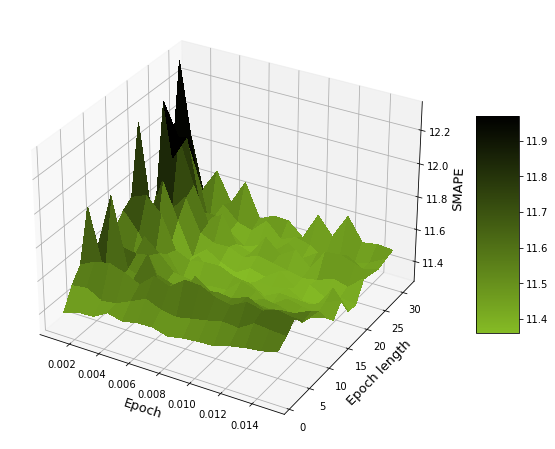

In [28]:
epsg_narrow = PlotTuningResults3D(results_grid_epsg, 'epsilon', 'epoch', 'smape')

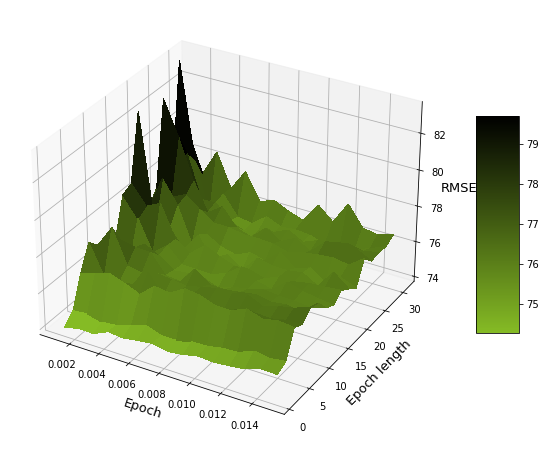

In [29]:
epsg_narrow = PlotTuningResults3D(results_grid_epsg, 'epsilon', 'epoch', 'rmse')

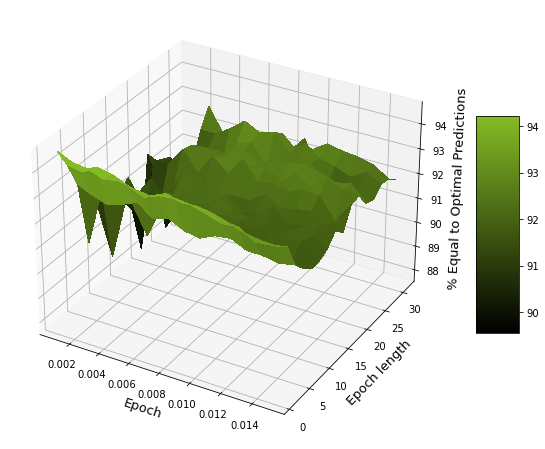

In [30]:
epsg_narrow = PlotTuningResults3D(results_grid_epsg, 'epsilon', 'epoch', 'mimic_optimal')

In [31]:
print(epsg_narrow[['epoch', 
                   'epsilon', 
                   'smape', 
                   'rmse', 
                   'mimic_optimal']].sort_values('smape').head(10).to_latex(index = False, float_format = "%.3f"))

\begin{tabular}{rrrrr}
\toprule
 epoch &  epsilon &  smape &   rmse &  mimic\_optimal \\
\midrule
    19 &    0.008 & 11.298 & 75.222 &         93.147 \\
    19 &    0.006 & 11.325 & 75.171 &         92.928 \\
    19 &    0.004 & 11.327 & 75.379 &         92.875 \\
    21 &    0.007 & 11.350 & 75.440 &         92.939 \\
    27 &    0.006 & 11.357 & 75.381 &         93.308 \\
    21 &    0.013 & 11.360 & 75.399 &         92.949 \\
    19 &    0.013 & 11.361 & 75.595 &         92.525 \\
    19 &    0.012 & 11.362 & 76.077 &         92.620 \\
    29 &    0.011 & 11.362 & 75.428 &         92.934 \\
    15 &    0.006 & 11.364 & 75.570 &         92.596 \\
\bottomrule
\end{tabular}



### UCB

#### Broad

In [ ]:
years = range(2011, 2012)
results = []
alphas = [0.01, 0.1, .5, 1]
sw_lengths = [1, 24, 168, 672, 2016, 4032, 8760]

for j in years:
    for alpha in alphas:
        for sw in sw_lengths:

            df_test_j = df_final[(df_final['datetime']>str(j-1)+'-12-31 23:00:00')&(df_final['datetime']<str(j+1)+'-01-01 00:00:00')]

            train_years = str(j-2)[-2:]+str(j-1)[-2:]
            name = path+"Models/train_"+train_years+".dat"
            xgb_model = pickle.load(open(name, "rb"))  

            print(j, ' | Predicting | ',datetime.datetime.now().time())
            models = {'naive':naive, 'xgb':xgboost}
            selector = MAB(models, ucb)
            selector.execute(df_test_j, alpha = alpha, sw_length = sw)
            results.append(selector)

            print(j, alpha, sw, ' | Finished   | ',
                  datetime.datetime.now().time(), ' | ', 
                  smape(selector.history_y,selector.history_pred))      

In [ ]:
pickle.dump(results, open(path+"Results/ucb_grid_broad.dat", "wb"))

In [32]:
results_grid_ucb_broad = pickle.load(open(path+'Results/ucb_grid_broad.dat', "rb"))

In [ ]:
ucb_broad = PlotTuningResults3D(results_grid_ucb_broad, 'alpha', 'sw', 'smape', type = 'broad')

In [ ]:
ucb_broad = PlotTuningResults3D(results_grid_ucb_broad, 'alpha', 'sw', 'smape', type = 'broad')

In [ ]:
ucb_broad = PlotTuningResults3D(results_grid_ucb_broad, 'alpha', 'sw', 'mimic_optimal', type = broad)

In [ ]:
print(ucb_broad[['sw', 
                 'alpha', 
                 'smape', 
                 'rmse', 
                 'mimic_optimal']].sort_values(['smape']).to_latex(index = False, float_format = "%.3f"))

#### Narrow 1

In [ ]:
years = range(2011, 2012)
results = []
alphas = [.9, .93, .95, .97, 1, 1.03, 1.05, 1.07, 1.09]
sw_lengths = [8088, 8640, 8736, 8760, 8784]

for j in years:
    for alpha in alphas:
        for sw in sw_lengths:

            df_test_j = df_final[(df_final['datetime']>str(j-1)+'-12-31 23:00:00')&(df_final['datetime']<str(j+1)+'-01-01 00:00:00')]

            train_years = str(j-2)[-2:]+str(j-1)[-2:]
            name = path+"Models/train_"+train_years+".dat"
            xgb_model = pickle.load(open(name, "rb"))  

            print(j, ' | Predicting | ',datetime.datetime.now().time())
            models = {'naive':naive, 'xgb':xgboost}
            selector = MAB(models, ucb)
            selector.execute(df_test_j, alpha = alpha, sw_length = sw)
            results.append(selector)

            print(j, alpha, sw, ' | Finished   | ',
                  datetime.datetime.now().time(), ' | ', 
                  smape(selector.history_y,selector.history_pred))      

In [ ]:
pickle.dump(results, open(path+"Results/ucb_grid_narrow1.dat", "wb"))

In [ ]:
results_grid_ucb_narrow1 = pickle.load(open(path+'Results/ucb_grid_narrow1.dat', "rb"))

In [ ]:
ucb_narrow1 = PlotTuningResults3D(results_grid_ucb_narrow1, 'alpha', 'sw', 'smape', type = 'ucb1')

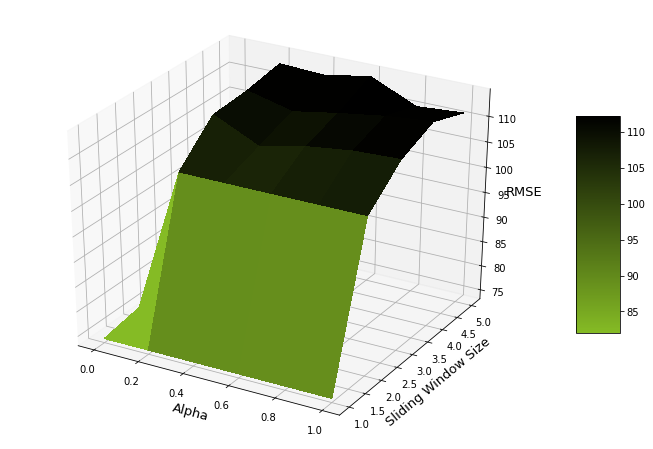

In [ ]:
ucb_narrow1 = PlotTuningResults3D(results_grid_ucb_narrow1, 'alpha', 'sw', 'rmse', type = 'ucb1')

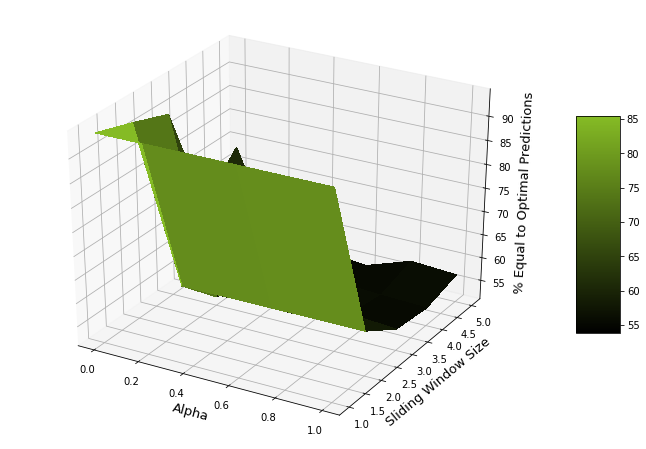

\begin{tabular}{rrrrr}
\toprule
 sw &  alpha &  smape &    rmse &  mimic\_optimal \\
\midrule
  1 &  0.000 & 11.396 &  73.952 &         94.693 \\
  1 &  0.600 & 11.396 &  73.952 &         94.693 \\
  1 &  0.400 & 11.396 &  73.952 &         94.693 \\
  1 &  1.000 & 11.396 &  73.952 &         94.693 \\
  1 &  0.200 & 11.396 &  73.952 &         94.693 \\
  1 &  0.800 & 11.396 &  73.952 &         94.693 \\
  2 &  0.000 & 11.769 &  75.286 &         92.273 \\
  3 &  0.000 & 12.184 &  77.741 &         89.577 \\
  5 &  0.000 & 14.551 &  95.203 &         73.708 \\
  4 &  0.000 & 15.656 &  98.106 &         65.896 \\
  2 &  1.000 & 16.200 & 104.673 &         60.525 \\
  2 &  0.800 & 16.201 & 104.671 &         60.515 \\
  2 &  0.600 & 16.204 & 104.672 &         60.472 \\
  2 &  0.400 & 16.207 & 104.691 &         60.434 \\
  2 &  0.200 & 16.212 & 104.714 &         60.368 \\
  3 &  0.400 & 16.331 & 107.266 &         57.985 \\
  3 &  0.600 & 16.556 & 109.249 &         57.041 \\
  5 &  0.800 & 16.615 

In [ ]:
ucb_narrow1 = PlotTuningResults3D(results_grid_ucb, 'alpha', 'sw', 'mimic_optimal')

In [ ]:
print(ucb_narrow1[['sw', 'alpha', 'smape', 'rmse', 'mimic_optimal']].sort_values(['smape']).to_latex(index = False, float_format = "%.3f"))

#### Narrow 2

In [ ]:
years = range(2011, 2012)
results = []
alphas = [0, 0.2, 0.4, 0.6, 0.8, 1]
sw_lengths = [1, 2, 3, 4, 5]

for j in years:
    for alpha in alphas:
        for sw in sw_lengths:

            df_test_j = df_final[(df_final['datetime']>str(j-1)+'-12-31 23:00:00')&(df_final['datetime']<str(j+1)+'-01-01 00:00:00')]

            train_years = str(j-2)[-2:]+str(j-1)[-2:]
            name = path+"Models/train_"+train_years+".dat"
            xgb_model = pickle.load(open(name, "rb"))  

            print(j, ' | Predicting | ',datetime.datetime.now().time())
            models = {'naive':naive, 'xgb':xgboost}
            selector = MAB(models, ucb)
            selector.execute(df_test_j, alpha = alpha, sw_length = sw)
            results.append(selector)

            print(j, alpha, swpickle.dump(results, open(path+"Results/ucb_grid_narrow1.dat", "wb"))

            print(j, alpha, sw, ' | Finished   | ',
                  datetime.datetime.now().time(), ' | ', 
                  smape(selector.history_y,selector.history_pred))  

In [ ]:
pickle.dump(results, open(path+"Results/ucb_grid_narrow2.dat", "wb"))

In [34]:
results_grid_ucb_narrow2 = pickle.load(open(path+'Results/ucb_grid_narrow2.dat', "rb"))

In [ ]:
ucb_narrow2 = PlotTuningResults3D(results_grid_ucb_narrow2, 'alpha', 'sw', 'smape')

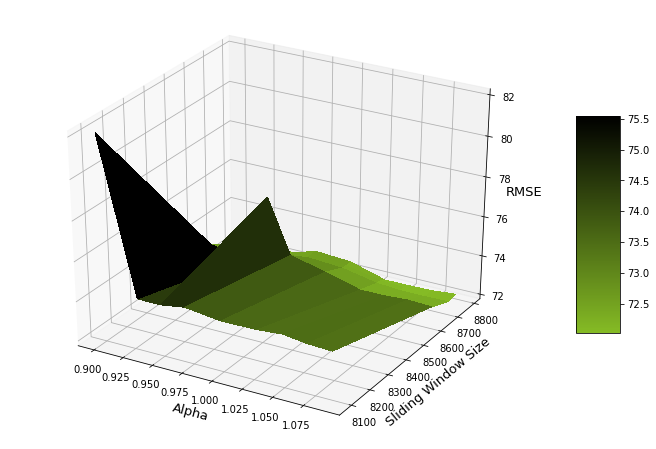

,smape,alpha,sw,mimic_optimal,rmse
38,10.894374,1.07,8760,97.349235,71.973656
34,10.896132,1.05,8784,97.400618,72.012092
27,10.904694,1.03,8736,97.475979,72.166133
29,10.906152,1.03,8784,97.523936,72.005779
33,10.906377,1.05,8760,97.430876,72.058630
39,10.906438,1.07,8784,97.264169,72.038000
28,10.908831,1.03,8760,97.422313,72.131313
44,10.908916,1.09,8784,97.371501,72.151405
43,10.909253,1.09,8760,97.323544,72.129451
32,10.909860,1.05,8736,97.306987,72.080989


In [ ]:
ucb_narrow2 = PlotTuningResults3D(results_grid_ucb_narrow2, 'alpha', 'sw', 'rmse')

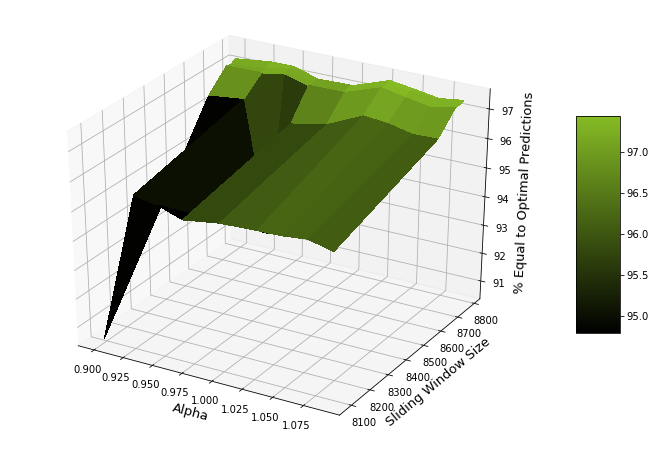

In [ ]:
ucb_narrow2 = PlotTuningResults3D(results_grid_ucb_narrow2, 'alpha', 'sw', 'mimic_optimal')

In [ ]:
print(ucb_narrow2 = [['sw', 'alpha', 'smape', 'rmse', 'mimic_optimal']].head(10).sort_values(['smape']).to_latex(index = False, float_format = "%.3f"))

\begin{tabular}{rrrrr}
\toprule
   sw &  alpha &  smape &   rmse &  mimic\_optimal \\
\midrule
 8760 &  1.070 & 10.894 & 71.974 &         97.349 \\
 8784 &  1.050 & 10.896 & 72.012 &         97.401 \\
 8736 &  1.030 & 10.905 & 72.166 &         97.476 \\
 8784 &  1.030 & 10.906 & 72.006 &         97.524 \\
 8760 &  1.050 & 10.906 & 72.059 &         97.431 \\
 8784 &  1.070 & 10.906 & 72.038 &         97.264 \\
 8760 &  1.030 & 10.909 & 72.131 &         97.422 \\
 8784 &  1.090 & 10.909 & 72.151 &         97.372 \\
 8760 &  1.090 & 10.909 & 72.129 &         97.324 \\
 8736 &  1.050 & 10.910 & 72.081 &         97.307 \\
\bottomrule
\end{tabular}



## Running the Procedures

#### Epsilon Greedy

In [ ]:
years = range(2011, 2021)
results = []

for j in years:    

    df_test_j = df_final[(df_final['datetime']>str(j-1)+'-12-31 23:00:00')&(df_final['datetime']<str(j+1)+'-01-01 00:00:00')]
    
    train_years = str(j-2)[-2:]+str(j-1)[-2:]
    name = path+"Models/train_"+train_years+".dat"
    xgb_model = pickle.load(open(name, "rb"))  
    
    print(j, ' | Predicting | ',datetime.datetime.now().time())
    models = {'naive':naive, 'xgb':xgboost}
    selector = MAB(models, epsg)
    selector.execute_zone_reset(df_test_j, epsilon = 0.008, epoch_length = 21)
    results.append(selector)
    
    print(j, ' | Finished   | ',datetime.datetime.now().time(), ' | ', smape(selector.history_y,selector.history_pred))      

In [ ]:
pickle.dump(results, open(path+"Results/epsg_0008_21.dat", "wb"))

#### UCB-dynamic

In [ ]:
years = range(2011, 2021)
results = []

for j in years:    

    df_test_j = df_final[(df_final['datetime']>str(j-1)+'-12-31 23:00:00')&(df_final['datetime']<str(j+1)+'-01-01 00:00:00')]
    
    train_years = str(j-2)[-2:]+str(j-1)[-2:]
    name = path+"Models/train_"+train_years+".dat"
    xgb_model = pickle.load(open(name, "rb"))  
    
    print(j, ' | Predicting | ',datetime.datetime.now().time())
    models = {'naive':naive, 'xgb':xgboost}
    selector = MAB(models, ucb)
    selector.execute_zone_reset(df_test_j, alpha = 1.07, sw_length = 8760)
    results.append(selector)
    
    print(j, ' | Finished   | ',datetime.datetime.now().time(), ' | ', smape(selector.history_y,selector.history_pred))      

In [ ]:
pickle.dump(results, open(path+"Results/ucb_107_8760.dat", "wb"))

#### UCB-static

In [ ]:
years = range(2011, 2021)
results = []

for j in years:    

    df_test_j = df_final[(df_final['datetime']>str(j-1)+'-12-31 23:00:00')&(df_final['datetime']<str(j+1)+'-01-01 00:00:00')]
    
    train_years = str(j-2)[-2:]+str(j-1)[-2:]
    name = path+"Models/train_"+train_years+".dat"
    xgb_model = pickle.load(open(name, "rb"))  
    
    print(j, ' | Predicting | ',datetime.datetime.now().time())
    models = {'naive':naive, 'xgb':xgboost}
    selector = MAB(models, ucb)
    selector.execute_zone_reset(df_test_j, alpha = 0, sw_length = 1)
    results.append(selector)
    
    print(j, ' | Finished   | ',datetime.datetime.now().time(), ' | ', smape(selector.history_y,selector.history_pred))      

In [ ]:
pickle.dump(results, open(path+"Results/ucb_0_1.dat", "wb"))

## 4.4.2 Validation Results

### Predictive Performance

In [49]:
epsg = pickle.load(open(path+"Results/epsg_0008_21.dat", "rb"))
ucb1 = pickle.load(open(path+"Results/UCB_0_1.dat", "rb"))
ucb2 = pickle.load(open(path+"Results/ucb_107_8760.dat", "rb"))
models_realistic = pickle.load(open(path+'Results/model_hurricane.dat', 'rb'))
pred_realistic = pickle.load(open(path+'Results/pred_hurricane.dat', 'rb'))

epsg_preds = []
ucb1_preds = []
ucb2_preds = []

for i in range(len(epsg)):
    epsg_year_preds = epsg[i].history_pred
    ucb1_year_preds = ucb1[i].history_pred
    ucb2_year_preds = ucb2[i].history_pred
    epsg_preds.append(epsg_year_preds)
    ucb1_preds.append(ucb1_year_preds)
    ucb2_preds.append(ucb2_year_preds)

df_test.sort_values(['year', 'PULocationID', 'datetime'], inplace = True)
df_test['epsg'] = [item for elem in epsg_preds for item in elem]
df_test['ucb1'] = [item for elem in ucb1_preds for item in elem]
df_test['ucb2'] = [item for elem in ucb2_preds for item in elem]

In [43]:
yearly_xgb_smape = []
yearly_xgb_rmse = []
yearly_naive_smape = []
yearly_naive_rmse = []
yearly_epsg_smape = []
yearly_epsg_rmse = []
yearly_ucb1_smape = []
yearly_ucb1_rmse = []
yearly_ucb2_smape = []
yearly_ucb2_rmse = []
yearly_titles = []
for title, group in df_test.groupby(['year']):
    yearly_titles.append(title)
    yearly_xgb_smape.append(smape(group['xgb'], group['y']))
    yearly_xgb_rmse.append(rmse(group['xgb'], group['y']))
    yearly_naive_smape.append(smape(group['naive'], group['y']))
    yearly_naive_rmse.append(rmse(group['naive'], group['y']))
    yearly_epsg_smape.append(smape(group['epsg'], group['y']))
    yearly_epsg_rmse.append(rmse(group['epsg'], group['y']))
    yearly_ucb1_smape.append(smape(group['ucb1'], group['y']))
    yearly_ucb1_rmse.append(rmse(group['ucb1'], group['y']))
    yearly_ucb2_smape.append(smape(group['ucb2'], group['y']))
    yearly_ucb2_rmse.append(rmse(group['ucb2'], group['y']))

yearly = pd.DataFrame({'date': yearly_titles, 
                       'epsg_smape':yearly_epsg_smape, 'ucb1_smape':yearly_ucb1_smape, 'ucb2_smape':yearly_ucb2_smape,
                       'epsg_rmse':yearly_epsg_rmse, 'ucb1_rmse':yearly_ucb1_rmse, 'ucb2_rmse':yearly_ucb2_rmse})

In [44]:
yearly

,date,epsg_smape,ucb1_smape,ucb2_smape,epsg_rmse,ucb1_rmse,ucb2_rmse
0,2011,11.386054,11.396253,10.894374,75.643246,73.951651,71.973656
1,2012,10.405402,10.332980,10.053942,72.052441,69.932710,69.878152
2,2013,10.602790,10.446224,10.262932,72.041013,69.963743,69.868225
3,2014,10.617194,10.512850,10.236068,69.156472,67.050695,66.722921
4,2015,11.066711,10.957244,13.696896,64.769000,62.823350,79.643761
5,2016,11.870699,12.719206,19.234172,61.534573,65.054007,94.463308
6,2017,12.717280,12.895040,13.514678,57.808502,56.834432,60.575457
7,2018,12.802959,12.771160,12.155479,51.525194,49.294182,48.696548
8,2019,14.078605,14.007850,13.265606,45.369725,43.461684,42.815167
9,2020,38.129000,40.465188,37.459493,26.697840,25.857137,25.563110


In [45]:
df_year = df_test[df_test['year']==2011]

In [46]:
print(sum(np.array(models_realistic) != np.array(xgb_only[0].history_model))/len(xgb_only[0].history_model)*100)
print(sum(np.array(epsg[0].history_model) != np.array(xgb_only[0].history_model))/len(xgb_only[0].history_model)*100)
print(sum(np.array(ucb1[0].history_model) != np.array(xgb_only[0].history_model))/len(xgb_only[0].history_model)*100)
print(sum(np.array(ucb2[0].history_model) != np.array(xgb_only[0].history_model))/len(xgb_only[0].history_model)*100)

0.5349486460718099
7.429334825328134
5.183920711133441
2.4172599439360116


In [50]:
print('XGB vs Hurricane', dm_test(df_year['y'], df_year['xgb'],  pred_realistic))
print('XGB vs epsg', dm_test(df_year['y'], df_year['xgb'],  df_year['epsg']))
print('XGB vs ucb1', dm_test(df_year['y'], df_year['xgb'],  df_year['ucb1']))
print('XGB vs ucb2', dm_test(df_year['y'], df_year['xgb'],  df_year['ucb2']))

XGB vs Hurricane dm_return(DM=3.20647177769196, p_value=0.0013439759972307614)
XGB vs epsg dm_return(DM=-29.76950211421697, p_value=2.9719636063241853e-194)
XGB vs ucb1 dm_return(DM=-18.694239933393966, p_value=6.570363496479311e-78)
XGB vs ucb2 dm_return(DM=-15.355208367029979, p_value=3.5406245808388417e-53)


### Model Switching Behaviour

[Text(0.5, 15.0, 'Day of the Year'), Text(33.0, 0.5, 'Taxi Zone')]

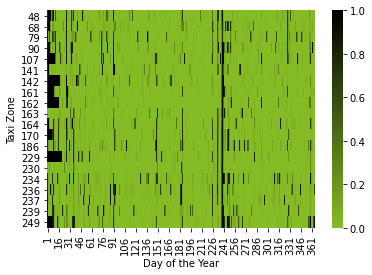

In [51]:
# EPSG model usage
model_selections = epsg[0].history_model
model_selections_bin = [1 if i=='naive' else 0 for i in model_selections]

df_year['epsg_selection'] = model_selections_bin
epsg_averages = df_year.groupby(['PULocationID', 'doy'], as_index = False).mean()[['PULocationID', 'doy', 'epsg_selection']]
data_heatmap_epsg = epsg_averages.pivot_table(index = ['PULocationID'], columns = 'doy', values = 'epsg_selection')

ax = sns.heatmap(data_heatmap_epsg, cbar = True, cmap = cdict_r)
ax.set(xlabel = 'Day of the Year', ylabel = 'Taxi Zone')

[Text(0.5, 15.0, 'Day of the Year'), Text(33.0, 0.5, 'Taxi Zone')]

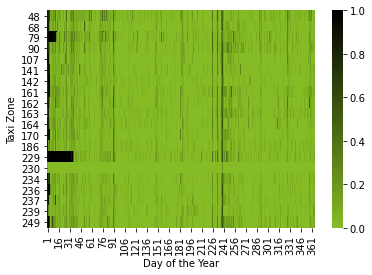

In [52]:
# UCB model usage
model_selections = ucb1[0].history_model
model_selections_bin = [1 if i=='naive' else 0 for i in model_selections]

df_year['ucb_selection'] = model_selections_bin
ucb_averages = df_year.groupby(['PULocationID', 'doy'], as_index = False).mean()[['PULocationID', 'doy', 'ucb_selection']]
data_heatmap_ucb = ucb_averages.pivot_table(index = ['PULocationID'], columns = 'doy', values = 'ucb_selection')

ax = sns.heatmap(data_heatmap_ucb, cbar = True, cmap = cdict_r)
ax.set(xlabel = 'Day of the Year', ylabel = 'Taxi Zone')

[Text(0.5, 15.0, 'Day of the Year'), Text(33.0, 0.5, 'Taxi Zone')]

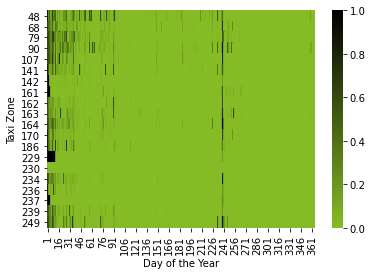

In [53]:
# UCB model usage
model_selections = ucb2[0].history_model
model_selections_bin = [1 if i=='naive' else 0 for i in model_selections]

df_year['ucb_selection'] = model_selections_bin
ucb_averages = df_year.groupby(['PULocationID', 'doy'], as_index = False).mean()[['PULocationID', 'doy', 'ucb_selection']]
data_heatmap_ucb = ucb_averages.pivot_table(index = ['PULocationID'], columns = 'doy', values = 'ucb_selection')

ax = sns.heatmap(data_heatmap_ucb, cbar = True, cmap = cdict_r)
ax.set(xlabel = 'Day of the Year', ylabel = 'Taxi Zone')

smape xgb on day 239 240 are 59.176780818426195
smape naive on day 239 240 are 33.68503695243362
smape epsg on day 239 240 are 30.763465929553647
smape ucb1 on day 239 240 are 45.596942153589815
smape ucb2 on day 239 240 are 56.252369214711536
rmse xgb on day 239 240 are 68.59796124533295
rmse naive on day 239 240 are 49.9005532774067
rmse epsg on day 239 240 are 53.26561261077146
rmse ucb1 on day 239 240 are 61.86532654860521
rmse ucb2 on day 239 240 are 66.46972223730525


<AxesSubplot:xlabel='Time', ylabel='Trips'>

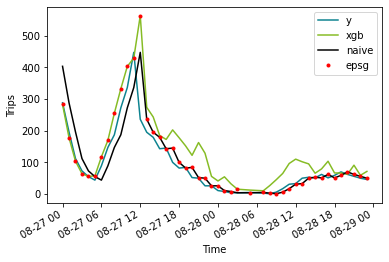

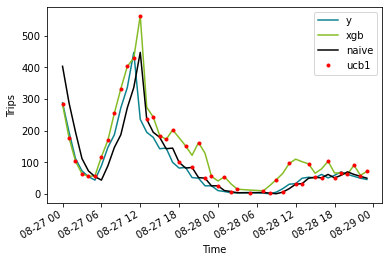

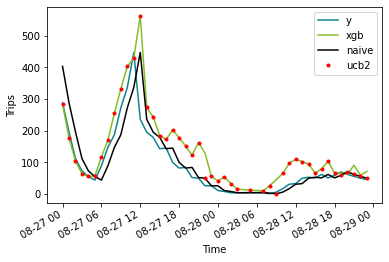

In [55]:
# Hurricane Irene 2011
day = 239
zone = 237
df_year_zone = df_year[(df_year['PULocationID']==zone)]

print('smape xgb on day', day, day + 1, 'are', 
      smape(df_year_zone[(df_year_zone['doy']==day)|(df_year_zone['doy']==day+1)]['y'], 
            df_year_zone[(df_year_zone['doy']==day)|(df_year_zone['doy']==day+1)]['xgb']))
print('smape naive on day', day, day + 1, 'are', 
      smape(df_year_zone[(df_year_zone['doy']==day)|(df_year_zone['doy']==day+1)]['y'], 
            df_year_zone[(df_year_zone['doy']==day)|(df_year_zone['doy']==day+1)]['naive']))
print('smape epsg on day', day, day + 1, 'are', 
      smape(df_year_zone[(df_year_zone['doy']==day)|(df_year_zone['doy']==day+1)]['y'], 
            df_year_zone[(df_year_zone['doy']==day)|(df_year_zone['doy']==day+1)]['epsg']))
print('smape ucb1 on day', day, day + 1, 'are', 
      smape(df_year_zone[(df_year_zone['doy']==day)|(df_year_zone['doy']==day+1)]['y'], 
            df_year_zone[(df_year_zone['doy']==day)|(df_year_zone['doy']==day+1)]['ucb1']))
print('smape ucb2 on day', day, day + 1, 'are', 
      smape(df_year_zone[(df_year_zone['doy']==day)|(df_year_zone['doy']==day+1)]['y'], 
            df_year_zone[(df_year_zone['doy']==day)|(df_year_zone['doy']==day+1)]['ucb2']))

print('rmse xgb on day', day, day + 1, 'are', 
      rmse(df_year_zone[(df_year_zone['doy']==day)|(df_year_zone['doy']==day+1)]['y'], 
           df_year_zone[(df_year_zone['doy']==day)|(df_year_zone['doy']==day+1)]['xgb']))
print('rmse naive on day', day, day + 1, 'are', 
      rmse(df_year_zone[(df_year_zone['doy']==day)|(df_year_zone['doy']==day+1)]['y'], 
           df_year_zone[(df_year_zone['doy']==day)|(df_year_zone['doy']==day+1)]['naive']))
print('rmse epsg on day', day, day + 1, 'are', 
      rmse(df_year_zone[(df_year_zone['doy']==day)|(df_year_zone['doy']==day+1)]['y'], 
           df_year_zone[(df_year_zone['doy']==day)|(df_year_zone['doy']==day+1)]['epsg']))
print('rmse ucb1 on day', day, day + 1, 'are', 
      rmse(df_year_zone[(df_year_zone['doy']==day)|(df_year_zone['doy']==day+1)]['y'], 
           df_year_zone[(df_year_zone['doy']==day)|(df_year_zone['doy']==day+1)]['ucb1']))
print('rmse ucb2 on day', day, day + 1, 'are', 
      rmse(df_year_zone[(df_year_zone['doy']==day)|(df_year_zone['doy']==day+1)]['y'], 
           df_year_zone[(df_year_zone['doy']==day)|(df_year_zone['doy']==day+1)]['ucb2']))

df_year_zone[(df_year_zone['doy']==day)|(df_year_zone['doy']==day+1)].plot(x = 'datetime', 
                                                                           y = ['y', 'xgb', 'naive', 'epsg'], 
                                                                           legend = True, xlabel = 'Time', 
                                                                           ylabel = 'Trips', 
                                                                           color = ['#0D8390', '#86BC25', '#000000', 'red'],
                                                                           style = ['-', '-', '-', '.'],
                                                                           fontsize = 13)
plt.ylabel('Trips',fontdict={'fontsize':15})
plt.xlabel('Date',fontdict={'fontsize':15})
df_year_zone[(df_year_zone['doy']==day)|(df_year_zone['doy']==day+1)].plot(x = 'datetime', 
                                                                           y = ['y', 'xgb', 'naive', 'ucb1'], 
                                                                           legend = True, 
                                                                           xlabel = 'Time', 
                                                                           ylabel = 'Trips', 
                                                                           color = ['#0D8390', '#86BC25', '#000000', 'red'],
                                                                           style = ['-', '-', '-', '.'],
                                                                           fontsize = 13)
plt.ylabel('Trips',fontdict={'fontsize':15})
plt.xlabel('Date',fontdict={'fontsize':15})
df_year_zone[(df_year_zone['doy']==day)|(df_year_zone['doy']==day+1)].plot(x = 'datetime', 
                                                                           y = ['y', 'xgb', 'naive', 'ucb2'], 
                                                                           legend = True, 
                                                                           xlabel = 'Time', 
                                                                           ylabel = 'Trips', 
                                                                           color = ['#0D8390', '#86BC25', '#000000', 'red'],
                                                                           style = ['-', '-', '-', '.'],
                                                                           fontsize = 13)
plt.ylabel('Trips',fontdict={'fontsize':15})
plt.xlabel('Date',fontdict={'fontsize':15})

## 4.4.3 Testing Results

### Predictive Performance

In [56]:
df_testing = df_test[df_test['year']>2011]

In [57]:
print(yearly.to_latex(float_format="%.2f", index = False))

\begin{tabular}{rrrrrrr}
\toprule
 date &  epsg\_smape &  ucb1\_smape &  ucb2\_smape &  epsg\_rmse &  ucb1\_rmse &  ucb2\_rmse \\
\midrule
 2011 &       11.39 &       11.40 &       10.89 &      75.64 &      73.95 &      71.97 \\
 2012 &       10.41 &       10.33 &       10.05 &      72.05 &      69.93 &      69.88 \\
 2013 &       10.60 &       10.45 &       10.26 &      72.04 &      69.96 &      69.87 \\
 2014 &       10.62 &       10.51 &       10.24 &      69.16 &      67.05 &      66.72 \\
 2015 &       11.07 &       10.96 &       13.70 &      64.77 &      62.82 &      79.64 \\
 2016 &       11.87 &       12.72 &       19.23 &      61.53 &      65.05 &      94.46 \\
 2017 &       12.72 &       12.90 &       13.51 &      57.81 &      56.83 &      60.58 \\
 2018 &       12.80 &       12.77 &       12.16 &      51.53 &      49.29 &      48.70 \\
 2019 &       14.08 &       14.01 &       13.27 &      45.37 &      43.46 &      42.82 \\
 2020 &       38.13 &       40.47 &       37.46 &  

In [58]:
print('smape:', round(smape(df_testing['y'], df_testing['xgb']), 2), 
      round(smape(df_testing['y'], df_testing['naive']), 2), 
      round(smape(df_testing['y'], df_testing['epsg']), 2), round(smape(df_testing['y'], df_testing['ucb1']),2),  
      round(smape(df_testing['y'], df_testing['ucb2']), 2))
print('rmse:', 
      round(rmse(df_testing['y'], df_testing['xgb']), 2), 
      round(rmse(df_testing['y'], df_testing['naive']),2), round(rmse(df_testing['y'], df_testing['epsg']), 2), 
      round(rmse(df_testing['y'], df_testing['ucb1']), 2),  round(rmse(df_testing['y'], df_testing['ucb2']),2))

smape: 15.31 28.07 14.58 14.89 15.44
rmse: 56.08 117.29 59.67 58.5 65.13


In [59]:
equality_epsg = []
equality_ucb1 = []
equality_ucb2 = []
dm_test_epsg = []
dm_test_ucb1 = []
dm_test_ucb2 = []
dm_p_epsg = []
dm_p_ucb1 = []
dm_p_ucb2 = []


for j in range(0, 10):
    equality_epsg.append(sum(np.array(epsg[j].history_model) != 'xgb')/len(xgb_only[j].history_model)*100)
    equality_ucb1.append(sum(np.array(ucb1[j].history_model) != 'xgb')/len(xgb_only[j].history_model)*100)
    equality_ucb2.append(sum(np.array(ucb2[j].history_model) != 'xgb')/len(xgb_only[j].history_model)*100)
  
    dm_test_epsg.append(dm_test(epsg[j].history_y, xgb_only[j].history_pred, epsg[j].history_pred)[0])
    dm_test_ucb1.append(dm_test(epsg[j].history_y, xgb_only[j].history_pred, ucb1[j].history_pred)[0])
    dm_test_ucb2.append(dm_test(epsg[j].history_y, xgb_only[j].history_pred, ucb2[j].history_pred)[0])
  
    dm_p_epsg.append(dm_test(epsg[j].history_y, xgb_only[j].history_pred, epsg[j].history_pred)[1])
    dm_p_ucb1.append(dm_test(epsg[j].history_y, xgb_only[j].history_pred, ucb1[j].history_pred)[1])
    dm_p_ucb2.append(dm_test(epsg[j].history_y, xgb_only[j].history_pred, ucb2[j].history_pred)[1])

In [60]:
evaluate_testing_results = pd.DataFrame()

epsg_models = []
ucb1_models = []
ucb2_models = []

for i in range(len(epsg)):
    epsg_year_models = epsg[i].history_model
    ucb1_year_models = ucb1[i].history_model
    ucb2_year_models = ucb2[i].history_model
    epsg_models.append(epsg_year_models)
    ucb1_models.append(ucb1_year_models)
    ucb2_models.append(ucb2_year_models)

evaluate_testing_results['epsg'] = [item for elem in epsg_models for item in elem]
evaluate_testing_results['ucb1'] = [item for elem in ucb1_models for item in elem]
evaluate_testing_results['ucb2'] = [item for elem in ucb2_models for item in elem]

In [61]:
print(sum(evaluate_testing_results['epsg']!='xgb')/len(evaluate_testing_results)*100)
print(sum(evaluate_testing_results['ucb1']!='xgb')/len(evaluate_testing_results)*100)
print(sum(evaluate_testing_results['ucb2']!='xgb')/len(evaluate_testing_results)*100)

12.496231931898546
11.01353295211373
17.47489578354612


In [62]:
print('XGB vs epsg', dm_test(df_testing['y'], df_testing['xgb'],  df_testing['epsg']))
print('XGB vs ucb1', dm_test(df_testing['y'], df_testing['xgb'],  df_testing['ucb1']))
print('XGB vs ucb2', dm_test(df_testing['y'], df_testing['xgb'],  df_testing['ucb2']))

XGB vs epsg dm_return(DM=-55.93880096021571, p_value=0.0)
XGB vs ucb1 dm_return(DM=-30.34031926038832, p_value=3.8595251703416935e-202)
XGB vs ucb2 dm_return(DM=-101.70622765262064, p_value=0.0)


In [63]:
print(pd.DataFrame({'year': [i for i in range(2011, 2021)],
             'epsg1': equality_epsg, 
             'UCB-d1': equality_ucb1,
             'UCB-s1': equality_ucb2,
             'epsg': dm_test_epsg, 
             'UCB-d': dm_test_ucb1,
             'UCB-s': dm_test_ucb2}).to_latex(index = False, float_format="%.3f"))

\begin{tabular}{rrrrrrr}
\toprule
 year &  epsg1 &  UCB-d1 &  UCB-s1 &    epsg &   UCB-d &   UCB-s \\
\midrule
 2011 &  7.429 &   5.184 &   2.417 & -29.770 & -18.694 & -15.355 \\
 2012 &  4.896 &   3.111 &   2.236 & -26.233 & -17.512 & -18.681 \\
 2013 &  5.188 &   2.703 &   2.169 & -24.464 &  -6.764 & -16.609 \\
 2014 &  5.085 &   2.962 &   2.042 & -23.151 &  -7.639 & -12.130 \\
 2015 &  4.830 &   2.807 &  22.289 & -21.820 & -11.842 & -58.627 \\
 2016 &  6.198 &  11.319 &  56.198 & -13.729 & -19.068 & -79.021 \\
 2017 &  8.422 &   8.319 &  14.355 & -20.900 & -14.271 & -25.063 \\
 2018 &  7.059 &   4.638 &   2.446 & -19.772 &  -9.481 & -14.203 \\
 2019 &  8.271 &   4.872 &   2.143 & -26.646 &  -9.603 & -12.849 \\
 2020 & 70.113 &  66.654 &  70.737 &  13.787 &  32.886 &  30.437 \\
\bottomrule
\end{tabular}



### Model Switching Behaviour

#### 2016

In [64]:
j = 5
years = [i for i in range(2011, 2021)]
df_test_year = df_test[df_test['year'] == years[j]]
print(years[j])

2016


[Text(0.5, 15.0, 'Day of the Year'), Text(33.0, 0.5, 'Taxi Zone')]

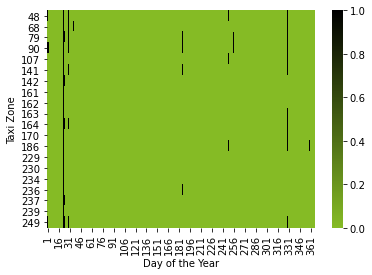

In [65]:
smape_naive_only = []
smape_xgb_only = []
location = []
doy = []
for title, group in df_test[df_test['year']==years[j]].groupby(['PULocationID', 'doy']):
    location.append(title[0])
    doy.append(title[1])
    smape_naive_only.append(smape(group['y'],group['naive']))
    smape_xgb_only.append(smape(group['y'],group['xgb']))

naive_best = [i for i in range(len(smape_naive_only)) if smape_naive_only[i] < smape_xgb_only[i]]
location_naive_best = [location[j] for j in naive_best]
doy_naive_best = [doy[j] for j in naive_best]
naive_best_loc_doy_smape = [str(location_naive_best[j])+' '+str(doy_naive_best[j]) for j in range(len(location_naive_best))]

rows = np.unique(location)
cols = np.unique(doy)
data_heatmap = pd.DataFrame(0, index = rows, columns = cols)

for i in range(len(location)):
    if str(location[i])+' '+str(doy[i]) in naive_best_loc_doy_smape:
        data_heatmap.loc[location[i], doy[i]] = 1

custom_cmap = cm.colors.ListedColormap(['#86BC25', '#000000'])

ax = sns.heatmap(data_heatmap, cbar = True, cmap = cdict_r)
ax.set(xlabel = 'Day of the Year', ylabel = 'Taxi Zone')

In [67]:
descriptives_days = data_heatmap.describe()
descriptives_days.sort_values('mean', axis = 1, ascending = False)

,23,24,329,360,30,25,186,1,330,9,...,138,137,136,135,134,133,132,131,130,366
count,20.0,20.0,20.000000,20.000000,20.00000,20.000000,20.000000,20.000000,20.000000,20.000000,...,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0
mean,1.0,1.0,0.550000,0.450000,0.35000,0.250000,0.200000,0.150000,0.150000,0.150000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,0.0,0.0,0.510418,0.510418,0.48936,0.444262,0.410391,0.366348,0.366348,0.366348,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,1.0,1.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,1.0,1.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,1.0,1.0,1.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,1.0,1.0,1.000000,1.000000,1.00000,0.250000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,1.0,1.0,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


[Text(0.5, 15.0, 'Day of the Year'), Text(33.0, 0.5, 'Taxi Zone')]

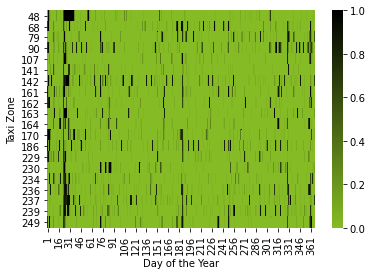

In [68]:
# EPSG model usage
model_selections = epsg[j].history_model
model_selections_bin = [1 if i=='naive' else 0 for i in model_selections]

df_test_year['epsg_selection'] = model_selections_bin
epsg_averages = df_test_year.groupby(['PULocationID', 'doy'], 
                                     as_index = False).mean()[['PULocationID', 'doy', 'epsg_selection']]
data_heatmap_epsg = epsg_averages.pivot_table(index = ['PULocationID'], columns = 'doy', values = 'epsg_selection')

ax = sns.heatmap(data_heatmap_epsg, cbar = True, cmap = cdict_r)
ax.set(xlabel = 'Day of the Year', ylabel = 'Taxi Zone')

[Text(0.5, 15.0, 'Day of the Year'), Text(33.0, 0.5, 'Taxi Zone')]

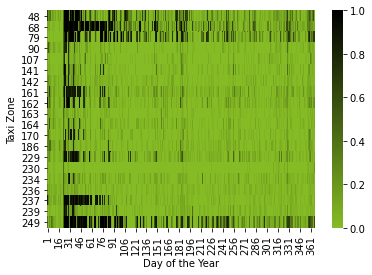

In [69]:
# UCB-d model usage
model_selections = ucb1[j].history_model
model_selections_bin = [1 if i=='naive' else 0 for i in model_selections]

df_test_year['ucb1_selection'] = model_selections_bin
ucb_averages = df_test_year.groupby(['PULocationID', 'doy'],
                                    as_index = False).mean()[['PULocationID', 'doy', 'ucb1_selection']]
data_heatmap_ucb = ucb_averages.pivot_table(index = ['PULocationID'], columns = 'doy', values = 'ucb1_selection')

ax = sns.heatmap(data_heatmap_ucb, cbar = True, cmap = cdict_r)
ax.set(xlabel = 'Day of the Year', ylabel = 'Taxi Zone')

[Text(0.5, 15.0, 'Day of the Year'), Text(33.0, 0.5, 'Taxi Zone')]

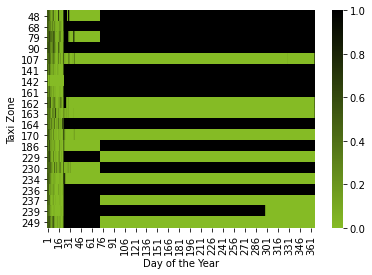

In [70]:
# UCB-s model usage
model_selections = ucb2[j].history_model
model_selections_bin = [1 if i=='naive' else 0 for i in model_selections]

df_test_year['ucb2_selection'] = model_selections_bin
ucb_averages = df_test_year.groupby(['PULocationID', 'doy'], 
                                    as_index = False).mean()[['PULocationID', 'doy', 'ucb2_selection']]
data_heatmap_ucb = ucb_averages.pivot_table(index = ['PULocationID'], columns = 'doy', values = 'ucb2_selection')

ax = sns.heatmap(data_heatmap_ucb, cbar = True, cmap = cdict_r)
ax.set(xlabel = 'Day of the Year', ylabel = 'Taxi Zone')

smape xgb on day 54 55 are 11.822544219901474
smape naive on day 54 55 are 37.816004413743556
smape epsg on day 54 55 are 11.822544219901474
smape ucb1 on day 54 55 are 31.528098376627284
smape ucb2 on day 54 55 are 37.816004413743556
rmse xgb on day 54 55 are 72.02550511043974
rmse naive on day 54 55 are 202.4721174219634
rmse epsg on day 54 55 are 72.02550511043974
rmse ucb1 on day 54 55 are 201.10369156602243
rmse ucb2 on day 54 55 are 202.4721174219634


<AxesSubplot:xlabel='Time', ylabel='Trips'>

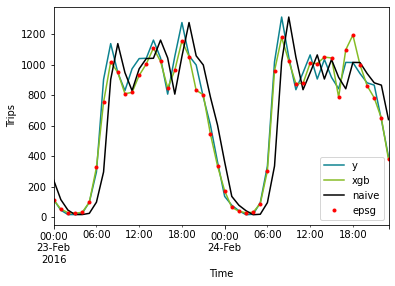

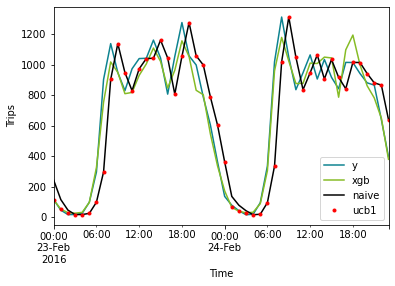

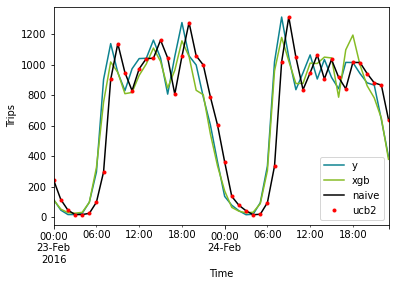

In [71]:
day = 54
zone = 237
df_test_year = df_test[df_test['year'] == years[j]]
df_year_zone = df_test_year[(df_test_year['PULocationID']==zone)]

print('smape xgb on day', day, day + 1, 'are', 
      smape(df_year_zone[(df_year_zone['doy']==day)|(df_year_zone['doy']==day+1)]['y'], 
            df_year_zone[(df_year_zone['doy']==day)|(df_year_zone['doy']==day+1)]['xgb']))
print('smape naive on day', day, day + 1, 'are', 
      smape(df_year_zone[(df_year_zone['doy']==day)|(df_year_zone['doy']==day+1)]['y'], 
            df_year_zone[(df_year_zone['doy']==day)|(df_year_zone['doy']==day+1)]['naive']))
print('smape epsg on day', day, day + 1, 'are', 
      smape(df_year_zone[(df_year_zone['doy']==day)|(df_year_zone['doy']==day+1)]['y'], 
            df_year_zone[(df_year_zone['doy']==day)|(df_year_zone['doy']==day+1)]['epsg']))
print('smape ucb1 on day', day, day + 1, 'are', 
      smape(df_year_zone[(df_year_zone['doy']==day)|(df_year_zone['doy']==day+1)]['y'], 
            df_year_zone[(df_year_zone['doy']==day)|(df_year_zone['doy']==day+1)]['ucb1']))
print('smape ucb2 on day', day, day + 1, 'are', 
      smape(df_year_zone[(df_year_zone['doy']==day)|(df_year_zone['doy']==day+1)]['y'], 
            df_year_zone[(df_year_zone['doy']==day)|(df_year_zone['doy']==day+1)]['ucb2']))

print('rmse xgb on day', day, day + 1, 'are', 
      rmse(df_year_zone[(df_year_zone['doy']==day)|(df_year_zone['doy']==day+1)]['y'], 
           df_year_zone[(df_year_zone['doy']==day)|(df_year_zone['doy']==day+1)]['xgb']))
print('rmse naive on day', day, day + 1, 'are', 
      rmse(df_year_zone[(df_year_zone['doy']==day)|(df_year_zone['doy']==day+1)]['y'], 
           df_year_zone[(df_year_zone['doy']==day)|(df_year_zone['doy']==day+1)]['naive']))
print('rmse epsg on day', day, day + 1, 'are', 
      rmse(df_year_zone[(df_year_zone['doy']==day)|(df_year_zone['doy']==day+1)]['y'], 
           df_year_zone[(df_year_zone['doy']==day)|(df_year_zone['doy']==day+1)]['epsg']))
print('rmse ucb1 on day', day, day + 1, 'are', 
      rmse(df_year_zone[(df_year_zone['doy']==day)|(df_year_zone['doy']==day+1)]['y'], 
           df_year_zone[(df_year_zone['doy']==day)|(df_year_zone['doy']==day+1)]['ucb1']))
print('rmse ucb2 on day', day, day + 1, 'are', 
      rmse(df_year_zone[(df_year_zone['doy']==day)|(df_year_zone['doy']==day+1)]['y'], 
           df_year_zone[(df_year_zone['doy']==day)|(df_year_zone['doy']==day+1)]['ucb2']))

df_year_zone[(df_year_zone['doy']==day)|(df_year_zone['doy']==day+1)].plot(x = 'datetime', 
                                                                           y = ['y', 'xgb', 'naive', 'epsg'], 
                                                                           legend = True, xlabel = 'Time', 
                                                                           ylabel = 'Trips', 
                                                                           color = ['#0D8390', '#86BC25', '#000000', 'red'], 
                                                                           style = ['-', '-', '-', '.'])
df_year_zone[(df_year_zone['doy']==day)|(df_year_zone['doy']==day+1)].plot(x = 'datetime', 
                                                                           y = ['y', 'xgb', 'naive', 'ucb1'], 
                                                                           legend = True, xlabel = 'Time', 
                                                                           ylabel = 'Trips', 
                                                                           color = ['#0D8390', '#86BC25', '#000000', 'red'], 
                                                                           style = ['-', '-', '-', '.'])
df_year_zone[(df_year_zone['doy']==day)|(df_year_zone['doy']==day+1)].plot(x = 'datetime', 
                                                                           y = ['y', 'xgb', 'naive', 'ucb2'], 
                                                                           legend = True, xlabel = 'Time', 
                                                                           ylabel = 'Trips', 
                                                                           color = ['#0D8390', '#86BC25', '#000000', 'red'], 
                                                                           style = ['-', '-', '-', '.'])

#### 2020

In [72]:
j = 9
years = [i for i in range(2011, 2021)]
df_test_year = df_test[df_test['year'] == years[j]]
print(years[j])

2020


[Text(0.5, 15.0, 'Day of the Year'), Text(33.0, 0.5, 'Taxi Zone')]

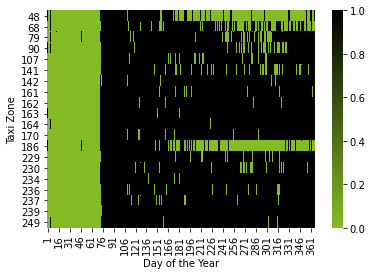

In [73]:
smape_naive_only = []
smape_xgb_only = []
location = []
doy = []
for title, group in df_test[df_test['year']==years[j]].groupby(['PULocationID', 'doy']):
    location.append(title[0])
    doy.append(title[1])
    smape_naive_only.append(smape(group['y'],group['naive']))
    smape_xgb_only.append(smape(group['y'],group['xgb']))

naive_best = [i for i in range(len(smape_naive_only)) if smape_naive_only[i] < smape_xgb_only[i]]
location_naive_best = [location[j] for j in naive_best]
doy_naive_best = [doy[j] for j in naive_best]
naive_best_loc_doy_smape = [str(location_naive_best[j])+' '+str(doy_naive_best[j]) for j in range(len(location_naive_best))]

rows = np.unique(location)
cols = np.unique(doy)
data_heatmap = pd.DataFrame(0, index = rows, columns = cols)

for i in range(len(location)):
    if str(location[i])+' '+str(doy[i]) in naive_best_loc_doy_smape:
        data_heatmap.loc[location[i], doy[i]] = 1

custom_cmap = cm.colors.ListedColormap(['#86BC25', '#000000'])

ax = sns.heatmap(data_heatmap, cbar = True, cmap = cdict_r)
ax.set(xlabel = 'Day of the Year', ylabel = 'Taxi Zone')

In [74]:
descriptives_days = data_heatmap.describe()
descriptives_days.sort_values('mean', axis = 1, ascending = False)

,78,90,102,101,100,99,98,97,96,95,...,24,55,54,53,52,51,50,25,26,56
count,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,...,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0
mean,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


[Text(0.5, 15.0, 'Day of the Year'), Text(33.0, 0.5, 'Taxi Zone')]

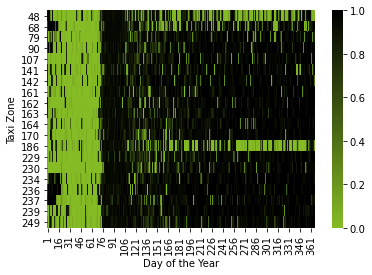

In [75]:
# EPSG model usage
model_selections = epsg[j].history_model
model_selections_bin = [1 if i=='naive' else 0 for i in model_selections]

df_test_year['epsg_selection'] = model_selections_bin
epsg_averages = df_test_year.groupby(['PULocationID', 'doy'], 
                                     as_index = False).mean()[['PULocationID', 'doy', 'epsg_selection']]
data_heatmap_epsg = epsg_averages.pivot_table(index = ['PULocationID'], columns = 'doy', values = 'epsg_selection')

ax = sns.heatmap(data_heatmap_epsg, cbar = True, cmap = cdict_r)
ax.set(xlabel = 'Day of the Year', ylabel = 'Taxi Zone')

[Text(0.5, 15.0, 'Day of the Year'), Text(33.0, 0.5, 'Taxi Zone')]

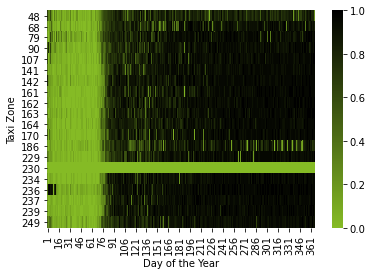

In [76]:
# UCB-d model usage
model_selections = ucb1[j].history_model
model_selections_bin = [1 if i=='naive' else 0 for i in model_selections]

df_test_year['ucb1_selection'] = model_selections_bin
ucb_averages = df_test_year.groupby(['PULocationID', 'doy'], 
                                    as_index = False).mean()[['PULocationID', 'doy', 'ucb1_selection']]
data_heatmap_ucb = ucb_averages.pivot_table(index = ['PULocationID'], columns = 'doy', values = 'ucb1_selection')

ax = sns.heatmap(data_heatmap_ucb, cbar = True, cmap = cdict_r)
ax.set(xlabel = 'Day of the Year', ylabel = 'Taxi Zone')

[Text(0.5, 15.0, 'Day of the Year'), Text(33.0, 0.5, 'Taxi Zone')]

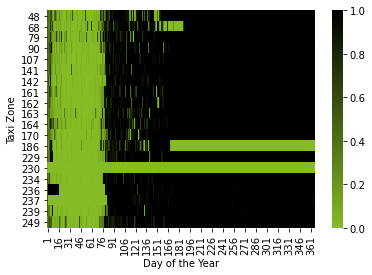

In [77]:
# UCB-s model usage
model_selections = ucb2[j].history_model
model_selections_bin = [1 if i=='naive' else 0 for i in model_selections]

df_test_year['ucb2_selection'] = model_selections_bin
ucb_averages = df_test_year.groupby(['PULocationID', 'doy'], 
                                    as_index = False).mean()[['PULocationID', 'doy', 'ucb2_selection']]
data_heatmap_ucb = ucb_averages.pivot_table(index = ['PULocationID'], columns = 'doy', values = 'ucb2_selection')

ax = sns.heatmap(data_heatmap_ucb, cbar = True, cmap = cdict_r)
ax.set(xlabel = 'Day of the Year', ylabel = 'Taxi Zone')